In [1]:
! git clone https://github.com/Saurabhbaghel/humanlike-ocr.git

Cloning into 'humanlike-ocr'...
remote: Enumerating objects: 737, done.
remote: Counting objects: 100% (737/737), done.
remote: Compressing objects: 100% (485/485), done.
remote: Total 737 (delta 296), reused 671 (delta 248), pack-reused 0
Receiving objects: 100% (737/737), 3.86 MiB | 9.24 MiB/s, done.
Resolving deltas: 100% (296/296), done.


In [2]:
! pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 8.9 MB/s eta 0:00:00


In [ ]:
! python /content/humanlike-ocr/training_atomic_char.py /content/humanlike-ocr/data/atoms_4300.csv 220 /content/humanlike-ocr/data/atoms_4300

In [1]:
devanagari_alphabets = [
    "अ", "आ", "इ", "ई", "उ", "ऊ", "ऋ", "ए", "ऐ", "ओ", "औ",
    "क", "ख", "ग", "घ", "ङ", "च", "छ", "ज", "झ", "ञ", "ट",
    "ठ", "ड", "ढ", "ण", "त", "थ", "द", "ध", "न", "प", "फ",
    "ब", "भ", "म", "य", "र", "ल", "व", "श", "ष", "स", "ह"
]

char_map = {idx: char for idx, char in enumerate(devanagari_alphabets)}

In [63]:
char_map[43]

'ह'

In [1]:
import os, shutil
import numpy as np
import torch
import cv2
from torchmetrics.classification import AveragePrecision, MulticlassAccuracy, MulticlassF1Score
from sklearn.model_selection import train_test_split
import pandas as pd
import torchvision as tv
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from ntm.encapsulated import EncapsulatedNTM

In [16]:
class ConvBlock(nn.Module):
    def __init__(self, input_channels: int, out_channels: int, kernel_size: tuple = (3, 3)):
        """Basic Conv Block with convolution layer, etc.

        Args:
            input_channels (int): _description_
            out_channels (int): _description_
            kernel_size (tuple, optional): _description_. Defaults to (3, 3).
        """
        super().__init__()
        
        self.input_channels = input_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        
        self.conv = nn.Conv2d(self.input_channels, self.out_channels, self.kernel_size)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(self.kernel_size)
        self.dropout = nn.Dropout2d()
        self.batchnorm = nn.BatchNorm2d(self.out_channels)
    
    def forward(self, x, training:bool = True):
        conv_res = self.conv(x)
        activated = self.relu(conv_res)
        pooled = self.maxpool(activated)
        if training:
            pooled = self.dropout(pooled)
        y = self.batchnorm(pooled)
        return y
    
    def __repr__(self):
        return f"ConvBlock({self.input_channels, self.out_channels, self.kernel_size})"


class FeedforwardController(nn.Module):
    def __init__(self, num_inputs:int, num_layers:int) -> None:
        super().__init__()
        self.num_inputs = num_inputs
        # self.num_outputs = num_outputs
        self.num_layers = num_layers
        # self.batch_size = batch_size
        self.device_ = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        # self.layer = [
        #     nn.Conv1d(1, 1, 1, device=self.device_),
        #     nn.LeakyReLU()
        # ]
        # self.layers = [
        #     nn.Linear(80, 100),
        #     nn.ReLU(),
        #     nn.Linear(100, 200),
        #     nn.ReLU(),
        #     nn.Linear(200, 300),
        #     nn.ReLU(),
        #     nn.Linear(300, 200),
        #     nn.ReLU(),
        #     nn.Linear(200, 80),
        #     nn.ReLU()
        # ]
        self.model_ = nn.Sequential(
            ConvBlock(self.num_inputs, 32, (2,2)),
            # ConvBlock(32, 32, (2,2)),
            ConvBlock(32, 64, (2,2))
            # ConvBlock(32, 64),
            # ConvBlock(64, 128),
            # ConvBlock(128, 256)
        )
        self.flatten = nn.Flatten()
        # self.fc_ = nn.Linear(64, 44, device=self.device_)
        # model_ = resnet50(pretrained=True)
        # self.feature_extractor = nn.Sequential(*list(model_.children())[:-1]).to(self.device_)
        
        # for layer_ in self.layers[::2]:
        #     nn.init.kaiming_normal_(layer_.weight)

        # self.feedforward = nn.ModuleList(
        #     self.layers #* self.num_layers
            # )
            # nn.LazyLinear(out_features=20, device=self.device_),
            # nn.Linear(20, self.num_outputs, device=self.device_)
            


    def forward(self, x, training:bool=True):
        # if x.ndim != 3:
        #     x = x.unsqueeze(1)
            # raise AssertionError(f"dimension of the input is {x.ndim} and shape is {x.size()}. It should be a 3d tensor.")
        # for layer in self.feature_extractor:
        #     x = layer(x)
        
        # x1 = ConvBlock(3, 32)(x)
        # print(x1.shape)
        # x2 = ConvBlock(32, 32)(x1)
        # print(x2.shape)
        # y = ConvBlock(32, 64)(x2)
        # print(y.shape)
        
        y = self.model_(x)

        # outp = self.fc_(y)
        return self.flatten(y)


In [21]:
test_tensor = torch.randn(size=(2 ,1, 40, 40))
model = FeedforwardController(1, 5)


y = model(test_tensor).squeeze()
# y = nn.Flatten()(y)
y.size()

torch.Size([2, 5184])

In [30]:
num_inputs = 1
num_outputs = 44
controller_size = 3136 #1024
controller_layers = 1
num_heads = 4
N, M = 10, 10

data_csv_path = "data/atoms_4300.csv"

img_dir = "data/atoms_4300"

batch_size = 2 #220

In [31]:
# defining the network
net = EncapsulatedNTM(
    num_inputs,
    num_outputs,
    controller_size,
    controller_layers,
    num_heads,
    N,
    M
)

/media/ashatya/Data/work/envs/torch/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [32]:
device_ = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device_)

EncapsulatedNTM(
  (ntm): NTM(
    (controller): FeedforwardController(
      (model_): Sequential(
        (0): ConvBlock((1, 32, (2, 2)))
        (1): ConvBlock((32, 64, (2, 2)))
      )
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    (memory): NTMMemory()
    (heads): ModuleList(
      (0): NTMReadHead(
        (memory): NTMMemory()
        (fc_read): Linear(in_features=3136, out_features=16, bias=True)
      )
      (1): NTMWriteHead(
        (memory): NTMMemory()
        (fc_write): Linear(in_features=3136, out_features=36, bias=True)
      )
      (2): NTMReadHead(
        (memory): NTMMemory()
        (fc_read): Linear(in_features=3136, out_features=16, bias=True)
      )
      (3): NTMWriteHead(
        (memory): NTMMemory()
        (fc_write): Linear(in_features=3136, out_features=36, bias=True)
      )
      (4): NTMReadHead(
        (memory): NTMMemory()
        (fc_read): Linear(in_features=3136, out_features=16, bias=True)
      )
      (5): NTMWriteHead(
     

In [33]:
# loss
loss_fn = torch.nn.BCELoss()

# optimizer
optimizer = torch.optim.Adam(net.parameters())

# metric
# metric = AveragePrecision(task="multiclass", num_classes=num_outputs)
metric = MulticlassAccuracy(num_classes=44)

In [34]:

class dataset(torch.utils.data.Dataset):
    def __init__(self, annotations_file, img_dir):
        self.images_csv = annotations_file.reset_index(drop=True) #pd.read_csv(annotations_file).reset_index(drop=True)
        self.img_dir = img_dir
        # self.transforms_ = tv.transforms.Compose([
        #     tv.transforms.Resize(40),
        #     # tv.transforms.CenterCrop(40),
        #     tv.transforms.ConvertImageDtype(torch.float),
        #     tv.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        # ])
        
    def transforms_(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if image.ndim == 3 else image
        thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 21, 10)
        # normed= cv2.normalize(thresh, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        skeleton = cv2.ximgproc.thinning(thresh, None, 1)
        image = cv2.resize(skeleton, (32, 32))
        return image

    def __len__(self):
        return len(self.images_csv)

    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir, self.images_csv.iloc[index, 0])
        # image = tv.io.image.read_image(img_path)
        image = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
        image_ = self.transforms_(image) #.to(device_)
        image = torch.from_numpy(image_)
        label = self.images_csv.iloc[index, 1]
        label = torch.nn.functional.one_hot(torch.tensor(label).to(torch.int64), num_classes=num_outputs)
        return image.unsqueeze(0), label

In [35]:
# splitting train and test
data = pd.read_csv(data_csv_path)
training_data, val_data = train_test_split(data, test_size=0.25, train_size=0.75, random_state=4340, shuffle=True)

In [36]:
# creating dataset
train_dataset = dataset(training_data, img_dir)
val_dataset = dataset(val_data, img_dir)

In [37]:
# creating dataloader
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

In [38]:
num_epochs = 5



# training loop

for epoch in range(num_epochs):
    print("Epoch {}".format(epoch))

    last_loss = 0.0
    list_outputs = []
    list_labels = []
    
    net.train(True)
    for i, data in enumerate(train_dataloader):
        running_loss = 0.0
        
        inputs, labels = data[0].to(device_), data[1].to(device_)
        # print(inputs.size())
        labels = labels.type(torch.float)
        optimizer.zero_grad()

        net.init_sequence(batch_size)
        
        training = True
        outputs, _ = net(inputs)
        avg_loss = loss_fn(outputs, labels)

        list_outputs.append(outputs)
        list_labels.append(torch.argmax(labels, dim=1))
        
        # avg_prec = metric(outputs, torch.argmax(labels, dim=1))
        # print(torch.argmax(outputs, dim=1), torch.argmax(labels, dim=1))
        avg_loss.backward()

        optimizer.step()

        running_loss += avg_loss.item()
        last_loss = running_loss
        # last_avg_prec = avg_prec
    outputs = torch.cat(list_outputs, dim=0)
    labels = torch.cat(list_labels).squeeze()
    acc = metric(outputs, labels)
    print("epoch {}, loss {:.3f}, train acc {:.3f}".format(epoch, last_loss, acc))
    torch.save(net, "model_new_{}_{}.pt".format("12-05-23", epoch))
    
    # validation
    list_outputs = []
    list_labels = []
    
    with torch.no_grad():
        running_vloss = 0.0
        for i, data in enumerate(val_dataloader):
            net.init_sequence(batch_size)

            vinputs, vlabels = data[0].to(device_), data[1].to(device_)
            vlabels = vlabels.type(torch.float)
            voutputs, _ = net(vinputs)
            list_outputs.append(voutputs)
            list_labels.append(torch.argmax(vlabels, dim=1))
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss
        
        voutputs = torch.cat(list_outputs, dim=0)
        vlabels = torch.cat(list_labels).squeeze()
        vacc = metric(voutputs, vlabels)
        avg_vloss = running_vloss / (i+1)
        print("Loss train {:.3f},  validation {:.3f},  val acc {:.3f}".format(avg_loss, avg_vloss, vacc))


Epoch 0


/media/ashatya/Data/work/self/thesis/humanlike-ocr/ntm/ntm.py:102: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(o), self.state


epoch 0, loss 0.000, train acc 0.687
Loss train 0.000,  validation 0.006,  val acc 0.964
Epoch 1
epoch 1, loss 0.006, train acc 0.973
Loss train 0.006,  validation 0.003,  val acc 0.979
Epoch 2
epoch 2, loss 0.001, train acc 0.984
Loss train 0.001,  validation 0.002,  val acc 0.991
Epoch 3


KeyboardInterrupt: 

#### Testing on handwritten characters which are unseen

In [109]:
a1 = torch.randn((5))
a2 = torch.randn((5))

a3 = torch.cat([a1, a2])
a3

tensor([ 0.7688, -1.1404, -0.1704,  0.8131, -1.0099,  1.3997, -1.6841,  1.6109,
         0.9257,  1.3935])

In [21]:
def transforms_(image, word:bool = False):
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if image.ndim == 3 else image
    # thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 21, 10)
    # normed= cv2.normalize(thresh, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    skeleton = cv2.ximgproc.thinning(gray, None, 1)
    image = cv2.resize(skeleton, (96, 32)) if word else cv2.resize(skeleton, (32, 32))
    return image

In [44]:
img1_path = "data/DevanagariHandwrittenCharacterDataset/Test/character_1_ka/1339.png"
img2_path = "data/DevanagariHandwrittenCharacterDataset/Test/character_2_kha/2786.png"
imgs = []
for img_path in [img1_path, img2_path]:
    image = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    image = transforms_(image)
    image = torch.from_numpy(image).expand(size = (1, 32, 32))
    imgs.append(image)
inp = torch.stack(imgs, dim=0)
# image.shape

In [45]:
inp.shape

torch.Size([2, 1, 32, 32])

In [46]:
image.unsqueeze(0).size()

torch.Size([1, 1, 32, 32])

In [47]:
image

tensor([[[  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ..., 255,   0,   0],
         ...,
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0]]], dtype=torch.uint8)

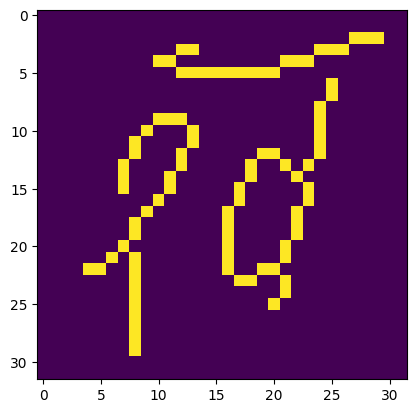

In [48]:
plt.imshow(np.array(image.squeeze(0)))

In [49]:
# net.init_sequence(2)
label, _ = net(inp)

/media/ashatya/Data/work/self/thesis/humanlike-ocr/ntm/ntm.py:102: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(o), self.state


In [50]:
labels = torch.argmax(label, dim=1)

In [56]:
labels[0].item()

23

In [58]:
char_map[labels[0].item()]

'ड'

# Increasing the memory

Now the atomic training is done.<br>
Memory is ready

In [4]:
net = torch.load("model_new_07-05-23_1.pt")

In [5]:
# shape of the memory
net.memory.memory.shape

torch.Size([2, 10, 10])

In [22]:
t_ = torch.zeros_like(net.memory.memory)

In [29]:
a = torch.from_numpy(np.ones((1, 10)))
a_ = a.T

### trying to get the contours for each character instead of words

#### Localizing the words

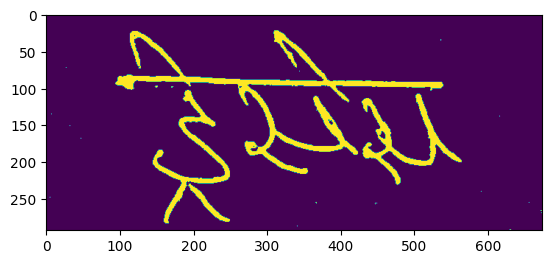

In [8]:
plt.imshow(img)

In [11]:
h, w = img.shape
h, w

(293, 674)

In [4]:
def make_and_plot_strips(img_path, word:bool = False):
    
    # reading the image
    img_path = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)

    # preprocess / transform
    img = transforms_(img_path, word)
    
    h, _ = img.shape
    strip_width = h//3
    plt.subplot(3, 1, 1)
    plt.imshow(img[:strip_width,:])
    plt.subplot(3, 1, 2)
    plt.imshow(img[strip_width:int(2.5*strip_width), :])
    plt.subplot(3, 1, 3)
    plt.imshow(img[int(2.5*strip_width):3*strip_width, :])

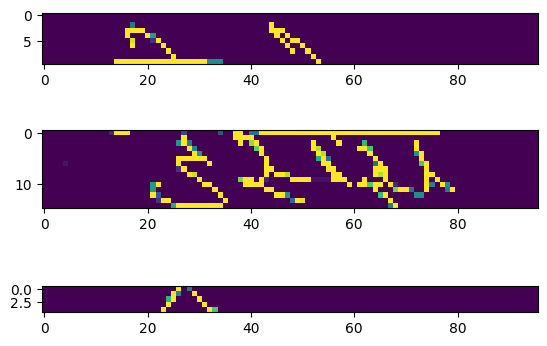

In [21]:
img_word1_path = "data/IIIT-HW-Hindi_v1/HindiSeg/test/6/1/1.jpg"

make_and_plot_strips(img_word1_path, True)

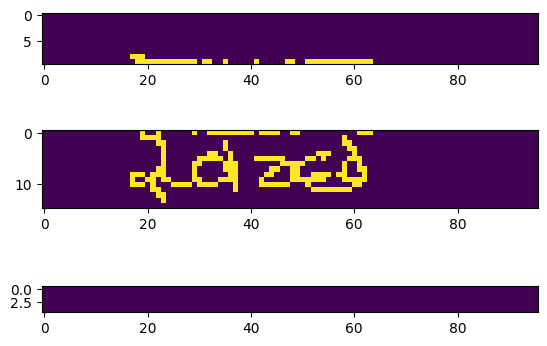

In [5]:
img_word2_path = "data/IIIT-HW-Hindi_v1/HindiSeg/test/6/1/7.jpg"

make_and_plot_strips(img_word2_path, True)

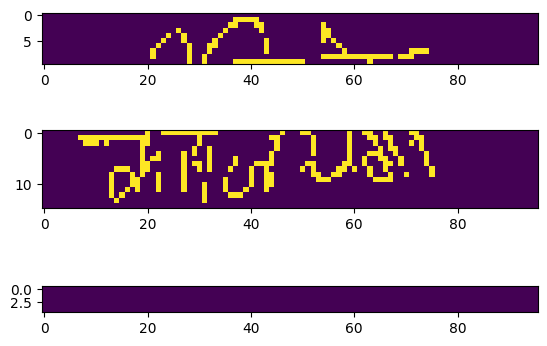

In [6]:
img_word2_path = "data/IIIT-HW-Hindi_v1/HindiSeg/test/6/1/10.jpg"

make_and_plot_strips(img_word2_path, True)

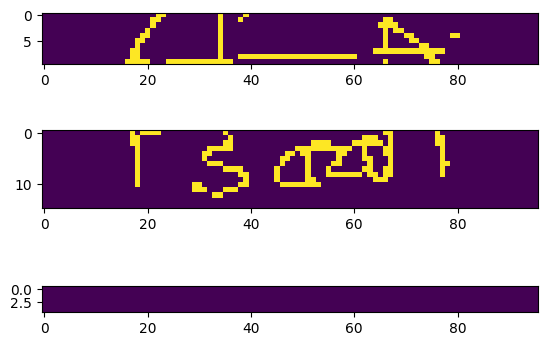

In [7]:
img_word2_path = "data/IIIT-HW-Hindi_v1/HindiSeg/test/6/1/20.jpg"

make_and_plot_strips(img_word2_path, True)

In [5]:
img_path = "data/IIIT-HW-Hindi_v1/HindiSeg/test/6/1/1.jpg"
img = cv2.imread(img_path)
img_ = transforms_(img, True)
h, _ = img_.shape
# np.concatenate([
#     img[: h//3, :],
    
# ])'=
img.shape

(293, 674, 3)

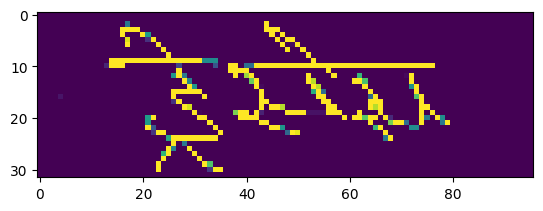

In [30]:
plt.imshow(img_)

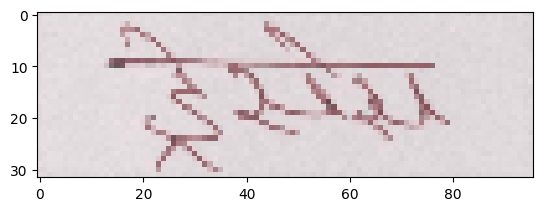

In [6]:
img_ = cv2.resize(img, (96, 32))
plt.imshow(img_)

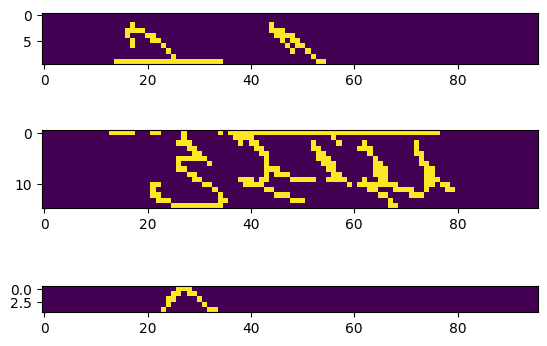

In [33]:
make_and_plot_strips(img_path, True)

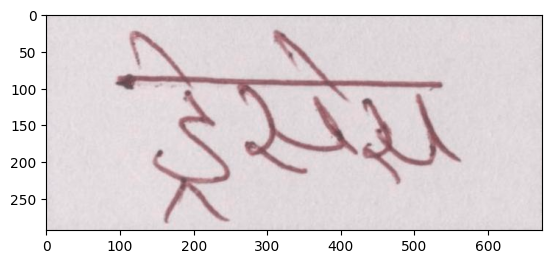

In [34]:
plt.imshow(img)

In [7]:
# img = np.resize(img, (32, 96))
img_2 = transforms_(img_, True)
img_2 = img_2.astype(np.uint8)

cntrs, _ = cv2.findContours(img_2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
# cv2.drawContours(img_, cntrs, -1, (0, 255, 0), 3)
# plt.imshow(img_)

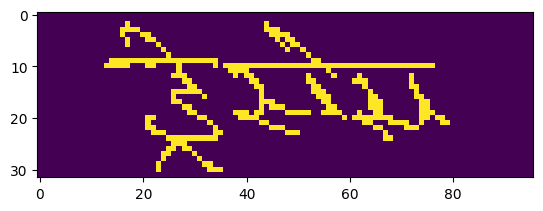

In [51]:
plt.imshow(img_2)

# Evaluation on Handwritten Atoms

In [32]:
# load model
net = torch.load("model_new_11-05-23_2.pt")

In [128]:
# # # make a dataset

# # # dest directory
dest = "data/atoms_evaluation_handwritten"

# # number of images to sample for each atom
# NUM_IMAGES = 20

# # directory of handwritten atoms
hw_dir_path = "data/DevanagariHandwrittenCharacterDataset/Test"

# # labels_dict
labels_dict = {"filename": [], "label": []}
 
# # list of the directories in the handwritten atoms directory
# for subfolder in os.listdir(hw_dir_path):
#     if "character" in subfolder:
#         base_idx = subfolder.split("_")[1]
#         if int(base_idx) < 34:
#             for hw_atom in os.listdir(os.path.join(hw_dir_path, subfolder))[:NUM_IMAGES]:
#                 label = int(base_idx) + 10
#                 shutil.copy(os.path.join(hw_dir_path, subfolder, hw_atom), dest)
#                 labels_dict["filename"].append(hw_atom)
#                 labels_dict["label"].append(label)

In [127]:
# # saving the dictionary as csv
annotations_csv = "data/evaluation_handwritten_atoms.csv"
# pd.DataFrame(labels_dict).to_csv(annotations_csv, index=False)

In [130]:
batch_size = 2

annotations_file = pd.read_csv(annotations_csv)
eval_dataset = dataset(annotations_file, dest)
eval_dataloader = torch.utils.data.DataLoader(eval_dataset, batch_size)

In [131]:
list_outputs = []
list_labels = []
for i, data in enumerate(eval_dataloader):
    with torch.no_grad():  
        running_loss = 0.0
        
        inputs, labels = data[0].to(device_), data[1].to(device_)
        # print(inputs.size())
        labels = labels.type(torch.float)
        # optimizer.zero_grad()

        # net.init_sequence(batch_size)
        
        training = False
        net.eval()
        outputs, _ = net(inputs)
        avg_loss = loss_fn(outputs, labels)
        list_outputs.append(outputs)
        list_labels.append(torch.argmax(labels, dim=1))
    
    #     avg_prec = metric(outputs, torch.argmax(labels, dim=1))
    #     print(torch.argmax(outputs, dim=1), torch.argmax(labels, dim=1))
        # print(torch.argmax(outputs, dim=1), torch.argmax(labels, dim=1))
        # avg_loss.backward()

        # optimizer.step()

        running_loss += avg_loss.item()
        last_loss = running_loss
        outputs = torch.cat(list_outputs, dim=0)
labels = torch.cat(list_labels).squeeze()
acc = metric(outputs, labels)
print("epoch {}, loss {:.3f}, train acc {:.3f}".format(epoch, last_loss, acc))

    # # validation
    # with torch.no_grad():
    #     running_vloss = 0.0
    #     for i, data in enumerate(val_dataloader):
    #         net.init_sequence(batch_size)

    #         vinputs, vlabels = data[0].to(device_), data[1].to(device_)
    #         vlabels = vlabels.type(torch.float)
    #         voutputs, _ = net(vinputs)
    #         vavg_prec = metric(voutputs, torch.argmax(vlabels, dim=1))
    #         vloss = loss_fn(voutputs, vlabels)
    #         running_vloss += vloss

    #     avg_vloss = running_vloss / (i+1)
    #     print("Loss train {:.3f},  validation {:.3f},  val avg prec {:.3f}".format(avg_loss, avg_vloss, vavg_prec))


/media/ashatya/Data/work/self/thesis/humanlike-ocr/ntm/ntm.py:102: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(o), self.state


epoch 3, loss 0.821, train acc 0.002


<i>So, the result on the handwritten characters is poor, we shall now try to train on hand written characters and evaluate on both.</i>

# Reversing the order.
##### Training on handwritten atoms and evaluating on the handwritten and printed

In [6]:
# creating a bigger dataset for Evaluation
# make a dataset for Eval

# dest directory
dest_validation = "data/atoms_evaluation_handwritten"

# annotations file for validation set
annotations_file_validation = "data/atoms_eval_handwritten.csv"



In [ ]:

# number of images to sample for each atom
NUM_IMAGES = 30

# directory of handwritten atoms
hw_dir_path = "data/DevanagariHandwrittenCharacterDataset/Test"


In [ ]:

# labels_dict
labels_dict = {"filename": [], "label": []}
 
# list of the directories in the handwritten atoms directory
for subfolder in os.listdir(hw_dir_path):
    if "character" in subfolder:
        base_idx = subfolder.split("_")[1]
        if int(base_idx) < 34:
            for hw_atom in os.listdir(os.path.join(hw_dir_path, subfolder))[:NUM_IMAGES]:
                label = int(base_idx) + 10
                shutil.copy(os.path.join(hw_dir_path, subfolder, hw_atom), dest_validation)
                labels_dict["filename"].append(hw_atom)
                labels_dict["label"].append(label)

In [57]:
# saving the csv for the evaluation images
pd.DataFrame(labels_dict).to_csv(annotations_file_validation, index=False)

In [5]:
# make dataset for training
# creating a bigger dataset for Evaluation
# make a dataset for Eval

# dest directory
dest_train = "data/atoms_training_handwritten"

# annotations file for training
annotations_file_training = "data/atoms_train_handwritten.csv"

In [ ]:

# number of images to sample for each atom
NUM_IMAGES = 100

# directory of handwritten atoms
hw_dir_path = "data/DevanagariHandwrittenCharacterDataset/Test"

# labels_dict
labels_dict = {"filename": [], "label": []}
 
# list of the directories in the handwritten atoms directory
for subfolder in os.listdir(hw_dir_path):
    if "character" in subfolder:
        base_idx = subfolder.split("_")[1]
        if int(base_idx) < 34:
            for hw_atom in os.listdir(os.path.join(hw_dir_path, subfolder))[50:50+NUM_IMAGES]:
                label = int(base_idx) + 10
                shutil.copy(os.path.join(hw_dir_path, subfolder, hw_atom), dest_train)
                labels_dict["filename"].append(hw_atom)
                labels_dict["label"].append(label)

In [59]:
# saving the annotations file for the training set
pd.DataFrame(labels_dict).to_csv(annotations_file_training, index=False)

In [7]:
# making dataset

class dataset(torch.utils.data.Dataset):
    def __init__(self, annotations_file, img_dir):
        self.images_csv = annotations_file.reset_index(drop=True) #pd.read_csv(annotations_file).reset_index(drop=True)
        self.img_dir = img_dir
        # self.transforms_ = tv.transforms.Compose([
        #     tv.transforms.Resize(40),
        #     # tv.transforms.CenterCrop(40),
        #     tv.transforms.ConvertImageDtype(torch.float),
        #     tv.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        # ])
        
    def transforms_(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if image.ndim == 3 else image
        thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 21, 10)
        # normed= cv2.normalize(thresh, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        skeleton = cv2.ximgproc.thinning(thresh, None, 1)
        image = cv2.resize(skeleton, (32, 32))
        return image

    def __len__(self):
        return len(self.images_csv)

    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir, self.images_csv.iloc[index, 0])
        # image = tv.io.image.read_image(img_path)
        image = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
        image_ = self.transforms_(image) #.to(device_)
        image = torch.from_numpy(image_)
        label = self.images_csv.iloc[index, 1]
        label = torch.nn.functional.one_hot(torch.tensor(label).to(torch.int64), num_classes=num_outputs)
        return image.unsqueeze(0), label

In [9]:
batch_size = 2

# train and validation dataset
train_dataset = dataset(pd.read_csv(annotations_file_training), dest_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)

# repeating for valid
val_dataset = dataset(pd.read_csv(annotations_file_validation), dest_validation)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

In [10]:
pd.read_csv(annotations_file_training)

,filename,label
0,26100.png,36
1,26103.png,36
2,26104.png,36
3,26107.png,36
4,26111.png,36
...,...,...
3295,4457.png,19
3296,4461.png,19
3297,4472.png,19
3298,4478.png,19


In [14]:
num_inputs = 1
num_outputs = 44
controller_size = 3136 #1024
controller_layers = 1
num_heads = 4
N, M = 10, 10

# data_csv_path = "data/atoms_4300.csv"

# img_dir = "data/atoms_4300"

batch_size = 2 #220

# defining the network
net = EncapsulatedNTM(
    num_inputs,
    num_outputs,
    controller_size,
    controller_layers,
    num_heads,
    N,
    M
)

/media/ashatya/Data/work/envs/torch/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [16]:
device_ = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net.to(device_)

EncapsulatedNTM(
  (ntm): NTM(
    (controller): FeedforwardController(
      (model_): Sequential(
        (0): ConvBlock((1, 32, (2, 2)))
        (1): ConvBlock((32, 64, (2, 2)))
      )
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    (memory): NTMMemory()
    (heads): ModuleList(
      (0): NTMReadHead(
        (memory): NTMMemory()
        (fc_read): Linear(in_features=3136, out_features=16, bias=True)
      )
      (1): NTMWriteHead(
        (memory): NTMMemory()
        (fc_write): Linear(in_features=3136, out_features=36, bias=True)
      )
      (2): NTMReadHead(
        (memory): NTMMemory()
        (fc_read): Linear(in_features=3136, out_features=16, bias=True)
      )
      (3): NTMWriteHead(
        (memory): NTMMemory()
        (fc_write): Linear(in_features=3136, out_features=36, bias=True)
      )
      (4): NTMReadHead(
        (memory): NTMMemory()
        (fc_read): Linear(in_features=3136, out_features=16, bias=True)
      )
      (5): NTMWriteHead(
     

In [18]:
# loss
loss_fn = torch.nn.BCELoss()

# optimizer
optimizer = torch.optim.Adam(net.parameters())

# metric
# metric = AveragePrecision(task="multiclass", num_classes=num_outputs)
metric = MulticlassAccuracy(num_classes=44)

In [19]:
num_epochs = 50


# training loop
for epoch in range(num_epochs):
    print("Epoch {}".format(epoch))

    last_loss = 0.0
    list_outputs = []
    list_labels = []
    
    net.train(True)
    for i, data in enumerate(train_dataloader):
        running_loss = 0.0
        
        inputs, labels = data[0].to(device_), data[1].to(device_)
        # print(inputs.size())
        labels = labels.type(torch.float)
        optimizer.zero_grad()

        net.init_sequence(batch_size)
        
        training = True
        outputs, _ = net(inputs)
        avg_loss = loss_fn(outputs, labels)

        list_outputs.append(outputs)
        list_labels.append(torch.argmax(labels, dim=1))
        
        # avg_prec = metric(outputs, torch.argmax(labels, dim=1))
        # print(torch.argmax(outputs, dim=1), torch.argmax(labels, dim=1))
        avg_loss.backward()

        optimizer.step()

        running_loss += avg_loss.item()
        last_loss = running_loss
        # last_avg_prec = avg_prec
    outputs = torch.cat(list_outputs, dim=0)
    labels = torch.cat(list_labels).squeeze()
    acc = metric(outputs, labels)
    print("epoch {}, loss {:.3f}, train acc {:.3f}".format(epoch, last_loss, acc))
    torch.save(net, "model_new_hw_{}_{}.pt".format("11-05-23", epoch))
    
    # validation
    list_outputs = []
    list_labels = []
    
    with torch.no_grad():
        running_vloss = 0.0
        for i, data in enumerate(val_dataloader):
            net.init_sequence(batch_size)

            vinputs, vlabels = data[0].to(device_), data[1].to(device_)
            vlabels = vlabels.type(torch.float)
            voutputs, _ = net(vinputs)
            list_outputs.append(voutputs)
            list_labels.append(torch.argmax(vlabels, dim=1))
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss
        
        voutputs = torch.cat(list_outputs, dim=0)
        vlabels = torch.cat(list_labels).squeeze()
        vacc = metric(voutputs, vlabels)
        avg_vloss = running_vloss / (i+1)
        print("Loss train {:.3f},  validation {:.3f},  val acc {:.3f}".format(avg_loss, avg_vloss, vacc))


Epoch 0


/media/ashatya/Data/work/self/thesis/humanlike-ocr/ntm/ntm.py:102: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(o), self.state


epoch 0, loss 0.009, train acc 0.286
Loss train 0.009,  validation 0.278,  val acc 0.055
Epoch 1
epoch 1, loss 0.002, train acc 0.312
Loss train 0.002,  validation 0.264,  val acc 0.070
Epoch 2
epoch 2, loss 0.000, train acc 0.409
Loss train 0.000,  validation 0.258,  val acc 0.077
Epoch 3
epoch 3, loss 0.026, train acc 0.451
Loss train 0.026,  validation 0.269,  val acc 0.102
Epoch 4
epoch 4, loss 0.001, train acc 0.397
Loss train 0.001,  validation 0.235,  val acc 0.135
Epoch 5
epoch 5, loss 0.000, train acc 0.406
Loss train 0.000,  validation 0.253,  val acc 0.142
Epoch 6
epoch 6, loss 0.000, train acc 0.459
Loss train 0.000,  validation 0.301,  val acc 0.131
Epoch 7
epoch 7, loss 0.000, train acc 0.440
Loss train 0.000,  validation 0.311,  val acc 0.145
Epoch 8
epoch 8, loss 2.535, train acc 0.273
Loss train 2.535,  validation 2.708,  val acc 0.038
Epoch 9
epoch 9, loss 4.545, train acc 0.023
Loss train 4.545,  validation 4.401,  val acc 0.023
Epoch 10
epoch 10, loss 4.545, train a

KeyboardInterrupt: 

# Pre training on printed, training again on Handwritten
### Evaluating on both

In [20]:
# Constants

num_inputs = 1
num_outputs = 44
controller_size = 3136 #1024
controller_layers = 1
num_heads = 4
N, M = 10, 10

data_csv_path = "data/atoms_4300.csv"

img_dir = "data/atoms_4300"

batch_size = 2 #220

In [21]:
# defining the network
net = EncapsulatedNTM(
    num_inputs,
    num_outputs,
    controller_size,
    controller_layers,
    num_heads,
    N,
    M
)

/media/ashatya/Data/work/envs/torch/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [22]:
device_ = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device_)

EncapsulatedNTM(
  (ntm): NTM(
    (controller): FeedforwardController(
      (model_): Sequential(
        (0): ConvBlock((1, 32, (2, 2)))
        (1): ConvBlock((32, 64, (2, 2)))
      )
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    (memory): NTMMemory()
    (heads): ModuleList(
      (0): NTMReadHead(
        (memory): NTMMemory()
        (fc_read): Linear(in_features=3136, out_features=16, bias=True)
      )
      (1): NTMWriteHead(
        (memory): NTMMemory()
        (fc_write): Linear(in_features=3136, out_features=36, bias=True)
      )
      (2): NTMReadHead(
        (memory): NTMMemory()
        (fc_read): Linear(in_features=3136, out_features=16, bias=True)
      )
      (3): NTMWriteHead(
        (memory): NTMMemory()
        (fc_write): Linear(in_features=3136, out_features=36, bias=True)
      )
      (4): NTMReadHead(
        (memory): NTMMemory()
        (fc_read): Linear(in_features=3136, out_features=16, bias=True)
      )
      (5): NTMWriteHead(
     

In [24]:

class dataset(torch.utils.data.Dataset):
    def __init__(self, annotations_file, img_dir):
        self.images_csv = annotations_file.reset_index(drop=True) #pd.read_csv(annotations_file).reset_index(drop=True)
        self.img_dir = img_dir
        # self.transforms_ = tv.transforms.Compose([
        #     tv.transforms.Resize(40),
        #     # tv.transforms.CenterCrop(40),
        #     tv.transforms.ConvertImageDtype(torch.float),
        #     tv.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        # ])
        
    def transforms_(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if image.ndim == 3 else image
        thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 21, 10)
        # normed= cv2.normalize(thresh, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        skeleton = cv2.ximgproc.thinning(thresh, None, 1)
        image = cv2.resize(skeleton, (32, 32))
        return image

    def __len__(self):
        return len(self.images_csv)

    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir, self.images_csv.iloc[index, 0])
        # image = tv.io.image.read_image(img_path)
        image = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
        image_ = self.transforms_(image) #.to(device_)
        image = torch.from_numpy(image_)
        label = self.images_csv.iloc[index, 1]
        label = torch.nn.functional.one_hot(torch.tensor(label).to(torch.int64), num_classes=num_outputs)
        return image.unsqueeze(0), label

In [28]:
# loss
loss_fn = torch.nn.BCELoss()

# optimizer
optimizer = torch.optim.Adam(net.parameters())

# metric
# metric = AveragePrecision(task="multiclass", num_classes=num_outputs)
# metric = MulticlassAccuracy(num_classes=44)
metric = MulticlassF1Score(num_classes=44)

In [29]:
num_epochs = 50


# training loop
for epoch in range(num_epochs):
    print("Epoch {}".format(epoch))

    last_loss = 0.0
    list_outputs = []
    list_labels = []
    
    net.train(True)
    for i, data in enumerate(train_dataloader):
        running_loss = 0.0
        
        inputs, labels = data[0].to(device_), data[1].to(device_)
        # print(inputs.size())
        labels = labels.type(torch.float)
        optimizer.zero_grad()

        net.init_sequence(batch_size)
        
        training = True
        outputs, _ = net(inputs)
        avg_loss = loss_fn(outputs, labels)

        list_outputs.append(outputs)
        list_labels.append(torch.argmax(labels, dim=1))
        
        # avg_prec = metric(outputs, torch.argmax(labels, dim=1))
        # print(torch.argmax(outputs, dim=1), torch.argmax(labels, dim=1))
        avg_loss.backward()

        optimizer.step()

        running_loss += avg_loss.item()
        last_loss = running_loss
        # last_avg_prec = avg_prec
    outputs = torch.cat(list_outputs, dim=0)
    labels = torch.cat(list_labels).squeeze()
    acc = metric(outputs, labels)
    print("epoch {}, loss {:.3f}, train acc {:.3f}".format(epoch, last_loss, acc))
    torch.save(net, "model_new_hw_{}_{}.pt".format("11-05-23", epoch))
    
    # validation
    list_outputs = []
    list_labels = []
    
    with torch.no_grad():
        running_vloss = 0.0
        for i, data in enumerate(val_dataloader):
            net.init_sequence(batch_size)

            vinputs, vlabels = data[0].to(device_), data[1].to(device_)
            vlabels = vlabels.type(torch.float)
            voutputs, _ = net(vinputs)
            list_outputs.append(voutputs)
            list_labels.append(torch.argmax(vlabels, dim=1))
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss
        
        voutputs = torch.cat(list_outputs, dim=0)
        vlabels = torch.cat(list_labels).squeeze()
        vacc = metric(voutputs, vlabels)
        avg_vloss = running_vloss / (i+1)
        print("Loss train {:.3f},  validation {:.3f},  val acc {:.3f}".format(avg_loss, avg_vloss, vacc))


Epoch 0


/media/ashatya/Data/work/self/thesis/humanlike-ocr/ntm/ntm.py:102: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(o), self.state


epoch 0, loss 1.050, train acc 0.303
Loss train 1.050,  validation 0.586,  val acc 0.083
Epoch 1
epoch 1, loss 4.545, train acc 0.048
Loss train 4.545,  validation 4.383,  val acc 0.001
Epoch 2
epoch 2, loss 4.545, train acc 0.001
Loss train 4.545,  validation 4.383,  val acc 0.001
Epoch 3
epoch 3, loss 4.545, train acc 0.001
Loss train 4.545,  validation 4.383,  val acc 0.001
Epoch 4
epoch 4, loss 4.545, train acc 0.001
Loss train 4.545,  validation 4.382,  val acc 0.001
Epoch 5
epoch 5, loss 4.545, train acc 0.004
Loss train 4.545,  validation 4.383,  val acc 0.001
Epoch 6
epoch 6, loss 4.545, train acc 0.006
Loss train 4.545,  validation 4.373,  val acc 0.001
Epoch 7
epoch 7, loss 4.545, train acc 0.002
Loss train 4.545,  validation 4.402,  val acc 0.001
Epoch 8
epoch 8, loss 4.545, train acc 0.001
Loss train 4.545,  validation 4.402,  val acc 0.001
Epoch 9
epoch 9, loss 4.545, train acc 0.001
Loss train 4.545,  validation 4.403,  val acc 0.001
Epoch 10
epoch 10, loss 4.545, train a

## Training on top of the pretrained model

In [1]:
import torch
import config
from dataset import dataset, dataloader
from training_loop import training
import pandas as pd

In [2]:
# pretrained model Path
pretrained_model_path = "model_new_11-05-23_1.pt"

# loading the pretrained model 
pretrained_model = torch.load(pretrained_model_path)

In [3]:
net = pretrained_model


In [9]:
# defining the dataset
hw_train_dataset = dataset(pd.read_csv(config.annotation_hw_training), config.hw_img_train_dir)
hw_val_dataset = dataset(pd.read_csv(config.annotation_hw_validation), config.hw_img_val_dir)

# defining the dataloader
hw_train_dataloader = torch.utils.data.DataLoader(hw_train_dataset, config.batch_size)
hw_val_dataloader = torch.utils.data.DataLoader(hw_val_dataset, config.batch_size)


In [10]:
# beginning the training

training(
    net, 
    config.num_epochs, 
    config.batch_size, 
    hw_train_dataloader, 
    hw_val_dataloader, 
    config.optimizer, 
    config.metric, 
    config.loss_fn
    )

Epoch 0


/media/ashatya/Data/work/self/thesis/humanlike-ocr/ntm/ntm.py:102: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(o), self.state


epoch 0, loss 0.239, train acc 0.011
Loss train 0.239,  validation 0.234,  val acc 0.004
Epoch 1
epoch 1, loss 0.161, train acc 0.012
Loss train 0.161,  validation 0.230,  val acc 0.005
Epoch 2
epoch 2, loss 0.174, train acc 0.012
Loss train 0.174,  validation 0.231,  val acc 0.008
Epoch 3
epoch 3, loss 0.251, train acc 0.012
Loss train 0.251,  validation 0.232,  val acc 0.006
Epoch 4
epoch 4, loss 0.190, train acc 0.014
Loss train 0.190,  validation 0.233,  val acc 0.005
Epoch 5
epoch 5, loss 0.220, train acc 0.011
Loss train 0.220,  validation 0.233,  val acc 0.010
Epoch 6
epoch 6, loss 0.207, train acc 0.013
Loss train 0.207,  validation 0.234,  val acc 0.009
Epoch 7


KeyboardInterrupt: 

## Increasing the capability of the model
#### Then we will retry the same experiments

In [1]:
from headers import *
from config import configuration
from dataset import dataset, dataloader
from training_loop import training

In [2]:
# initializing the configurations
config = configuration()

# initializing the constants
config.constants(
    N=50,
    M=50
)

# initializing the loss, optimizer and metric
loss_fn, optimizer, metric = config.loss_optimizer_metric()

# initializing the net
model = config.net()

# getting the train paths
annotations_train_csv_path, dir_train_path = config.paths(printed=False, train=True)

# getting the validation paths
annotations_val_csv_path, dir_val_path = config.paths(printed=False, train=False)

/media/ashatya/Data/work/envs/torch/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


<i>The memory size increased to 50*50.</i>

In [3]:
# preparing the dataset
# train dataset
train_dataset = dataset(annotations_train_csv_path, dir_train_path, config.num_classes)

# train dataloader
train_dataloader = dataloader(train_dataset, config.batch_size)

# validation dataset
val_dataset = dataset(annotations_val_csv_path, dir_val_path, config.num_classes)

# validation dataloader
val_dataloader = dataloader(val_dataset, config.batch_size)

In [4]:
# training loop
training(
    net=model,
    num_epochs=config.num_epochs,
    batch_size=config.batch_size,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    optimizer=optimizer,
    metric=metric,
    loss_fn=loss_fn
)

Epoch 0


/media/ashatya/Data/work/self/thesis/humanlike-ocr/ntm/ntm.py:102: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(o), self.state


epoch 0, loss 0.110, train acc 0.020
Loss train 0.110,  validation 0.111,  val acc 0.011
Epoch 1
epoch 1, loss 0.110, train acc 0.016
Loss train 0.110,  validation 0.111,  val acc 0.018
Epoch 2
epoch 2, loss 0.102, train acc 0.018
Loss train 0.102,  validation 0.111,  val acc 0.015
Epoch 3
epoch 3, loss 0.108, train acc 0.015
Loss train 0.108,  validation 0.111,  val acc 0.021
Epoch 4
epoch 4, loss 0.102, train acc 0.013
Loss train 0.102,  validation 0.111,  val acc 0.014
Epoch 5
epoch 5, loss 0.112, train acc 0.016
Loss train 0.112,  validation 0.111,  val acc 0.021
Epoch 6
epoch 6, loss 0.112, train acc 0.018
Loss train 0.112,  validation 0.111,  val acc 0.020
Epoch 7
epoch 7, loss 0.105, train acc 0.019
Loss train 0.105,  validation 0.111,  val acc 0.014
Epoch 8
epoch 8, loss 0.115, train acc 0.016
Loss train 0.115,  validation 0.111,  val acc 0.016
Epoch 9
epoch 9, loss 0.112, train acc 0.017
Loss train 0.112,  validation 0.111,  val acc 0.018
Epoch 10
epoch 10, loss 0.100, train a

In [40]:
img_ka_ = "data/DevanagariHandwrittenCharacterDataset/Train/character_1_ka/1340.png"
img_ka_ = cv2.imread(img_ka_)
img_ka = transforms_(img_ka_, False)

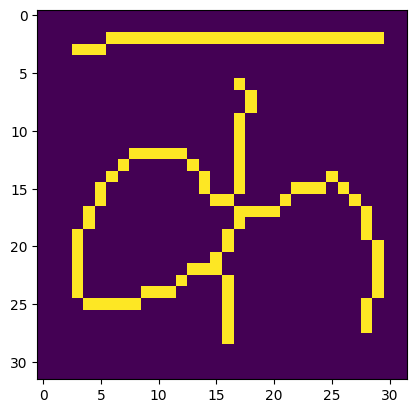

In [42]:
plt.imshow(img_ka)

In [13]:
net

EncapsulatedNTM(
  (ntm): NTM(
    (controller): FeedforwardController(
      (model_): Sequential(
        (0): ConvBlock((1, 32, (2, 2)))
        (1): ConvBlock((32, 64, (2, 2)))
      )
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    (memory): NTMMemory()
    (heads): ModuleList(
      (0): NTMReadHead(
        (memory): NTMMemory()
        (fc_read): Linear(in_features=3136, out_features=16, bias=True)
      )
      (1): NTMWriteHead(
        (memory): NTMMemory()
        (fc_write): Linear(in_features=3136, out_features=36, bias=True)
      )
      (2): NTMReadHead(
        (memory): NTMMemory()
        (fc_read): Linear(in_features=3136, out_features=16, bias=True)
      )
      (3): NTMWriteHead(
        (memory): NTMMemory()
        (fc_write): Linear(in_features=3136, out_features=36, bias=True)
      )
      (4): NTMReadHead(
        (memory): NTMMemory()
        (fc_read): Linear(in_features=3136, out_features=16, bias=True)
      )
      (5): NTMWriteHead(
     

In [43]:
tensor_ka = torch.from_numpy(img_ka).unsqueeze(0)
net()

/media/ashatya/Data/work/envs/torch/lib/python3.10/site-packages/torch/nn/functional.py:1338: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn("dropout2d: Received a 3D input to dropout2d and assuming that channel-wise "


ValueError: expected 4D input (got 3D input)

# Experimentation for Object detection 

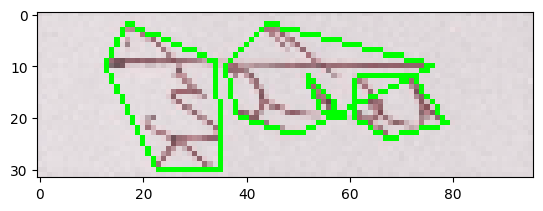

In [49]:
devanagari_contours = []
# for contour in cntrs:
#     x, y, w, h = cv2.boundingRect(contour)
#     aspect_ratio = w / float(h)
#     area = cv2.contourArea(contour)
#     if aspect_ratio > 0.5 and area > 100:
#         devanagari_contours.append(contour)

# Draw bounding boxes around the Devanagari characters
for contour in cntrs:
    # x, y, w, h = cv2.boundingRect(contour)
    # cv2.rectangle(img_, (x, y), (x + w, y + h), (0, 0, 255), 1)
    convexHull = cv2.convexHull(contour)
    cv2.drawContours(img_, [convexHull], -1, (0, 255, 0), 1)
plt.imshow(img_)

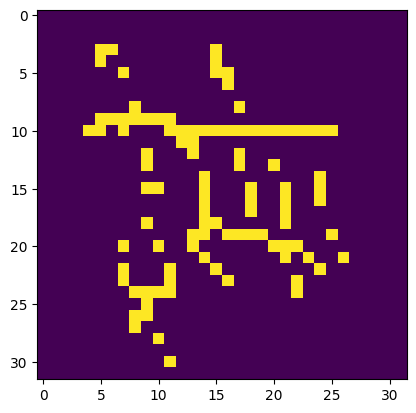

In [24]:
plt.imshow(img_2)

In [ ]:
import sys
from math import sin, cos, sqrt, pi
import cv2
# src = cv2.LoadImage('draw.jpg')
# cv2.NamedWindow("Source", 1)
# cv2.NamedWindow("Result", 1)
# dst = cv.CreateImage(cv.GetSize(src), 8, 1)
# color_dst = cv.CreateImage(cv.GetSize(src), 8, 3)
# storage = cv.CreateMemStorage(0)
lines = 0
canny_ = cv2.Canny(img_,1.0, 4.0, aperture_size=3)
cv2.CvtColor(canny_, color_dst, cv.CV_GRAY2BGR)
lines = cv.HoughLines2(dst, storage, cv.CV_HOUGH_PROBABILISTIC, 1, pi / 180, 10, 0, 10)
for line in lines:
    cv.Line(color_dst, line[0], line[1], cv.CV_RGB(0, 255, 0), 2, 8)
cornerMap = cv.CreateMat(dst.height, dst.width, cv.CV_32FC1)
cv.CornerHarris(dst,cornerMap,3)
for y in range(0,dst.height):
    for x in range (0, dst.width):
        harris = cv.Get2D(cornerMap, y, x)
        if harris[0] >10e-06:
            cv.Circle(color_dst, (x,y),2,cv.RGB(115,0,25))
cv.ShowImage("Source", src)
cv.ShowImage("Hough", color_dst)
cv2.SaveImage("draw_det.png", color_dst)
cv2.WaitKey()

In [1]:
import cv2

ModuleNotFoundError: No module named 'cv2'

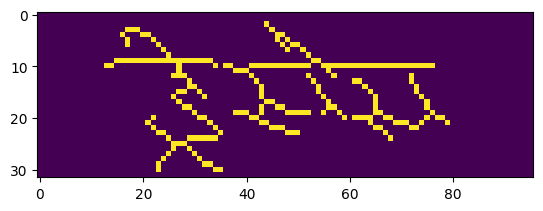

In [8]:
skeleton = cv2.ximgproc.thinning(img_2, None, 1)
plt.imshow(skeleton)

In [9]:
contours, _ = cv2.findContours(skeleton, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
for contour in contours:
    convexHull = cv2.convexHull(contour)
    cv2.drawContours(img_, [convexHull], -1, (255, 0, 0), 1)

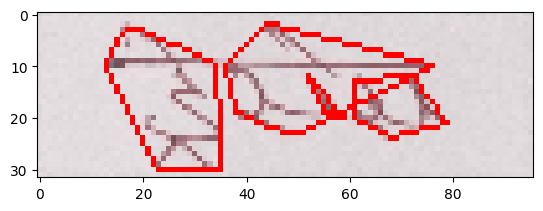

In [10]:
plt.imshow(img_)

# Experimentations

## Training Resnet50 on atoms

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.resnet import resnet50

In [ ]:
class Feature_Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = resnet50(pretrained=True)
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-1])
        dummy_out = self.backbone(torch.zeros(size=(3, 40, 40)).unsqueeze(0)).squeeze()
        self.fc = nn.Linear(dummy_out.size()[1], 32)
    def forward(self, x):
        x_ = self.backbone(x).squeeze()
        o = self.fc(x_)
        return o


In [21]:
class VanillaConvNet(nn.Module):
    def __init__(self, num_inputs, num_layers=5):
        super().__init__()
        self.model = FeedforwardController(num_inputs, num_layers)
        self.fc_ = nn.Linear(in_features = 5184, out_features= 44)
    def forward(self, x):
        feats = self.model(x)
        feats = self.fc_(feats)
        return F.softmax(feats, dim=1)


model = VanillaConvNet(3, 5)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

loss_fn = torch.nn.BCELoss()

metric = AveragePrecision(task="multiclass", num_classes=44)

for epoch in range(num_epochs):
    print("Epoch {}".format(epoch))

    last_loss = 0.0
    
    # net.train(True)
    for i, data in enumerate(train_dataloader):
        running_loss = 0.0
        
        inputs, labels = data[0].to(device_), data[1].to(device_)
        labels = labels.type(torch.float)
        optimizer.zero_grad()

        # net.init_sequence(batch_size)
        
        training = True
        outputs = model(inputs)
        avg_loss = loss_fn(outputs, labels)

        avg_prec = metric(outputs, torch.argmax(labels, dim=1))
        # print(torch.argmax(outputs, dim=1), torch.argmax(labels, dim=1))
        avg_loss.backward()

        optimizer.step()

        running_loss += avg_loss.item()
        last_loss = running_loss
        last_avg_prec = avg_prec
    print("batch {}, loss {:.3f}, train avg prec {:.3f}".format(i+1, last_loss, last_avg_prec))

    # validation
    with torch.no_grad():
        running_vloss = 0.0
        for i, data in enumerate(val_dataloader):
            net.init_sequence(batch_size)

            vinputs, vlabels = data[0].to(device_), data[1].to(device_)
            vlabels = vlabels.type(torch.float)
            voutputs = model(vinputs)
            vavg_prec = metric(voutputs, torch.argmax(vlabels, dim=1))
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

        avg_vloss = running_vloss / (i+1)
        print("Loss train {:.3f},  validation {:.3f},  val avg prec {:.3f}".format(avg_loss, avg_vloss, vavg_prec))


Epoch 0
batch 1650, loss 4.545, train avg prec 0.500
Loss train 4.545,  validation 4.446,  val avg prec 0.500
Epoch 1
batch 1650, loss 4.545, train avg prec 0.500
Loss train 4.545,  validation 4.446,  val avg prec 0.500
Epoch 2
batch 1650, loss 4.545, train avg prec 0.500
Loss train 4.545,  validation 4.446,  val avg prec 0.500
Epoch 3
batch 1650, loss 4.545, train avg prec 0.500


KeyboardInterrupt: 

In [ ]:
model

In [ ]:
import torch
import torch.nn as nn
from torchvision.io.image import read_image
import torchvision.transforms as transforms
from torchvision.models.vgg import VGG16_Weights, vgg16

In [ ]:
init_r = []
num_read_heads = 0
M = 120
heads = 2
for head in range(heads):
    # if head.is_read_head():
    init_r_bias = torch.randn(1, M) * 0.01
    # register_buffer("read{}_bias".format(num_read_heads), init_r_bias.data)
    init_r += [init_r_bias]
    num_read_heads += 1

In [ ]:
batch_size = 50
prev_reads  = [r.clone().repeat(batch_size, 1) for r in init_r]

In [ ]:
transforms_ = transforms.Compose([
    transforms.Resize(40),
    transforms.CenterCrop(40),
    transforms.ConvertImageDtype(torch.float),
    # transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
device = "cuda" if torch.cuda.is_available() else "cpu"
# feature_extractor_ = torch.hub.load('facebookresearch/WSL-Images'


In [ ]:
feature_extractor.eval()

In [ ]:
# img_path = os.path.join(img_dir, self.image_labels.iloc[index, 0])
img_path ="/content/humanlike-ocr/data/atomic_char/atomic_0_0.jpg"
image = read_image(img_path)
image = transforms_(image)
features = feature_extractor(image.unsqueeze(0)).squeeze()

In [ ]:
features.shape

In [ ]:
features = features[:80]

In [ ]:
inp = torch.cat([features]+prev_reads, dim=1)

In [ ]:
prev_reads[0].shape

In [ ]:
[features.unsqueeze(0)]+prev_reads

In [ ]:
from tqdm import tqdm
import os
import torch
import pandas as pd
import numpy as np


In [ ]:
image_labels = pd.read_csv("/content/humanlike-ocr/data/imgs_1500.csv")
img_dir = "/content/humanlike-ocr/data/imgs"

In [ ]:
# features index
features_= pd.read_csv("/content/humanlike-ocr/data/final_80_features.csv")
feats = features_.columns[:-1]
feats_idx = np.array(feats).astype(np.int32)

In [ ]:
device_ = torch.device("cuda")

# getting the features
feats_stacked_ = []
heads, bodys, tails = [], [], []
for index in tqdm(range(image_labels.shape[0])):
    img_path = os.path.join(img_dir, image_labels.iloc[index, 0])
    image = read_image(img_path)
    image = transforms_(image)
    c, h, w = image.size()
    slice_width = h//3
    head, body, tail = image[:, :slice_width, :], image[:, slice_width: 2*slice_width, :], image[:, 2*slice_width: 3*slice_width]
    heads.append(head)
    bodys.append(body)
    tails.append(tail)

heads = torch.stack(heads, dim=0)
bodys = torch.stack(bodys, dim=0)
tails = torch.stack(tails, dim=0)
    
    # stacked_ = torch.stack([head, body, tail], dim=0)

    # # getting the features of the three parts of the image
    # features = feature_extractor(stacked_).squeeze()[:, feats_idx] # getting the top 80 features only

    # # now the features which are stacked are to concatenated to get an array of the features
    # feat_list = [features[i, :] for i in range(features.size()[0])]
    # feats_catted = torch.cat(feat_list, dim=0)
    # # label = image_labels.iloc[index, 1]
    # # if target_transform:
    # #     label = target_transform(label)
    # feats_stacked_.append(feats_catted)

In [ ]:
model_ = vgg16(pretrained=True)
model_.classifier = model_.classifier[:-1]

In [ ]:
a_ = torch.stack([heads, bodys, tails], dim=2)

In [ ]:
heads.size()

In [ ]:
a_= torch.cat([heads, bodys, tails], dim=2)
a_.to(torch.device("cuda"))

In [ ]:
heads1, heads2, heads3 = heads[: 500].to(device_), heads[500: 1000].to(device_), heads[1000: 1500].to(device_)

In [ ]:
heads1.size()

In [ ]:
# concatenating heads
features_trimmed = []
feature_extractor.to(device_)
for head in [heads1, heads2, heads3]:
    with torch.no_grad():
        features = feature_extractor(head).squeeze()
    features_trimmed.append(features[:, feats_idx])
    # print(features.size())


In [ ]:
features_trimmed[0].size()
heads80 = torch.cat(features_trimmed, dim=0)
heads80.size()

In [ ]:
bodys1, bodys2, bodys3 = bodys[: 500].to(device_), bodys[500: 1000].to(device_), bodys[1000: 1500].to(device_)
# concatenating body
features_trimmed = []
feature_extractor.to(device_)
for body in [bodys1, bodys2, bodys3]:
    with torch.no_grad():
        features = feature_extractor(body).squeeze()
    features_trimmed.append(features[:, feats_idx])

features_trimmed[0].size()
bodys80 = torch.cat(features_trimmed, dim=0)
bodys80.size()

In [ ]:
tails1, tails2, tails3 = tails[: 500].to(device_), tails[500: 1000].to(device_), tails[1000: 1500].to(device_)
# concatenating tail
features_trimmed = []
feature_extractor.to(device_)
for tail in [tails1, tails2, tails3]:
    with torch.no_grad():
        features = feature_extractor(tail).squeeze()
    features_trimmed.append(features[:, feats_idx])

features_trimmed[0].size()
tails80 = torch.cat(features_trimmed, dim=0)
tails80.size()

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

In [ ]:
catted_features = torch.cat([heads80, bodys80, tails80], dim=1)
catted_features.size()

In [ ]:
image_labels[[str(i) for i in range(240)]] = catted_features.cpu().detach().numpy()

In [ ]:
image_labels.to_csv("features240_head_body_tail.csv", index=False)

In [ ]:
feature_extractor.to(torch.device("cuda"))
feats_stacked_ = []
for i in range(3):    
    # getting the features of the three parts of the image
    features = feature_extractor(a_[500*i:500*i+1].to(torch.device("cuda"))) # getting the top 80 features only
    features = features.squeeze()
    # now the features which are stacked are to concatenated to get an array of the features
    feat_list = [features[i, :] for i in range(features.size()[0])]
    feats_catted = torch.cat(feat_list, dim=0)
    # label = image_labels.iloc[index, 1]
    # if target_transform:
    #     label = target_transform(label)
    feats_stacked_.append(feats_catted)

The head, body and tail division of the image method is not working

## Trying VGG16 for the features

In [ ]:
model_ = vgg16(weights=VGG16_Weights)
feature_extractor_vgg16 = nn.Sequential(*list(model_.children())[:-2]).to(device_).eval()

In [ ]:
feature_extractor_vgg16 = model_

In [ ]:
feature_extractor_vgg16

In [ ]:
features_vgg16 = []
device = "cuda" if torch.cuda.is_available() else "cpu"
for index in tqdm(range(image_labels.shape[0])):
    img_path = os.path.join(img_dir, image_labels.iloc[index, 0])
    image = read_image(img_path)
    image = transforms_(image)
    c, h, w = image.size()
    with torch.no_grad():
        feats = feature_extractor_vgg16(image.unsqueeze(0).to(device))
    features_vgg16.append(feats.squeeze())
    # slice_width = h//3
    # head, body, tail = image[:, :slice_width, :], image[:, slice_width: 2*slice_width, :], image[:, 2*slice_width: 3*slice_width]
    # heads.append(head)
    # bodys.append(body)
    # tails.append(tail)

In [ ]:
feats = torch.stack(features_vgg16, dim=0)

In [ ]:
feats.size()

In [ ]:
image_labels[[str(i) for i in range(4096)]] = feats.cpu().detach().numpy()

In [ ]:
image_labels.to_csv("feats4096_1500files_vgg16.csv", index=False)

In [ ]:
cols_to_remove = []
for col in image_labels.columns:
    if image_labels[col].sum() == 0:
        cols_to_remove.append(col)

In [ ]:
len(cols_to_remove)

In [ ]:
class FeedforwardController(nn.Module):
    def __init__(self, num_inputs:int, num_layers:int) -> None:
        super().__init__()
        self.num_inputs = num_inputs
        # self.num_outputs = num_outputs
        self.num_layers = num_layers
        # self.batch_size = batch_size
        self.device_ = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.layer = [
            nn.Conv1d(1, 1, 1, device=self.device_),
            nn.LeakyReLU()
        ]
        
        self.feedforward = nn.Sequential(
            # nn.LazyLinear(out_features=20, device=self.device_),
            # nn.Linear(20, self.num_outputs, device=self.device_)
            nn.ModuleList(
            self.layer * self.num_layers
            )
        )

    def forward(self, x):
        if x.ndim != 3:
            raise AssertionError(f"dimension of the input is {x.ndim} and shape is {x.size()}. It should be a 3d tensor.")
        outp = self.feedforward(x)
        return outp